In [34]:
import torch
import os

In [35]:
BATCH_SIZE = 16          
LEARNING_RATE = 0.001
EPOCHS = 20              
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "checkpoints"
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")

NUM_WORKERS = 0          

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [36]:
from torch.utils.data import Dataset, DataLoader

In [37]:
import torch.nn as nn
import torch.optim as optim
import torchaudio
import random
from IPython.display import clear_output

In [38]:
class DeepfakeDataset(Dataset):
    def __init__(self, list_file, max_duration=4, target_sample_rate=16000, is_train = True):
        """
        Args:
            list_file (str): Path ke train_list.txt / val_list.txt
            is_train (bool): True = Aktifkan Augmentasi (Noise & Random Crop)
        """
        self.data = []
        self.max_duration = max_duration
        self.target_sample_rate = target_sample_rate
        self.num_samples = max_duration * target_sample_rate
        self.is_train = is_train

        # Validasi file keberadaan file list
        if not os.path.exists(list_file):
            raise FileNotFoundError(f"File {list_file} tidak ditemukan")

        with open(list_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    # parts[0] = path audio, parts[1] = label
                    self.data.append((parts[0], int(parts[1])))
    
    def __len__(self):
        return len(self.data)

    def _add_noise(self, waveform):
        # Tambahkan White Noise (Suara Kresek Statis)
        # Ambil amplitudo maksimal agar noise proporsional
        noise_amp = 0.005 * torch.rand(1).item() * torch.max(waveform)
        waveform = waveform + noise_amp * torch.randn_like(waveform)
        return waveform

    def _pad_or_trim(self, waveform):
        channels, length = waveform.shape
        if length > self.num_samples:
            if self.is_train:
                # Jika Training: Potong acak (biar model belajar semua bagian audio)
                start = torch.randint(0, length - self.num_samples, (1,)).item()
            else:
                # Jika Test/Val: Potong tengah (biar konsisten hasilnya saat diulang)
                start = (length - self.num_samples) // 2
            waveform = waveform[:, start : start + self.num_samples]
        elif length < self.num_samples:
            pad_amount = self.num_samples - length
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        return waveform

    def __getitem__(self, idx):
        audio_path, label = self.data[idx]
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
        except Exception as e:
            return torch.zeros(1, self.num_samples), torch.tensor(label, dtype=torch.long)

        # 1. Resample ke 16kHz
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        # 2. Mono Conversion (Stereo -> Mono)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # 3. Potong Durasi (Fixed Length)
        waveform = self._pad_or_trim(waveform)

        return waveform, torch.tensor(label, dtype=torch.long)

In [ ]:
class SimpleAudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer Preprocessing (Audio -> Gambar Spectrogram)
        self.spec_layer = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB()

        # Layer Augmentasi (SpecAugment)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=30)
        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)
        
        # Feature Extractor (CNN)
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            # Block 4
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), 
            nn.AdaptiveAvgPool2d((4, 4)) # Paksa output jadi ukuran 4x4
        )
        
        # Classifier
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128), 
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(128, 2) # Output: [Skor Asli, Skor Palsu]
        )

    def forward(self, x):
        # WAVEFORM AUGMENTATION
        if self.training:
            # Tambahkan noise putih secara acak ke SEMAUNYA (Asli & Palsu)
            noise_amp = 0.005 * torch.rand(1).to(x.device) * torch.max(x)
            x = x + noise_amp * torch.randn_like(x)
        
        # SPECTROGRAM CONVERSION
        x = self.spec_layer(x)
        x = self.to_db(x)

        # SPECTROGRAM AUGMENTATION (SpecAugment)
        if self.training:
            x = self.time_mask(x)
            x = self.freq_mask(x)

        # CNN INFERENCE
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [40]:
from torchinfo import summary

model = SimpleAudioCNN().to(DEVICE)

batch_size = 1
input_shape = (batch_size, 1, 16000) 

summary(
    model, 
    input_size=input_shape, 
    col_names=["input_size", "output_size", "num_params", "kernel_size"], 
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SimpleAudioCNN                           [1, 1, 16000]             [1, 2]                    --                        --
├─MelSpectrogram: 1-1                    [1, 1, 16000]             [1, 1, 64, 63]            --                        --
│    └─Spectrogram: 2-1                  [1, 1, 16000]             [1, 1, 513, 63]           --                        --
│    └─MelScale: 2-2                     [1, 1, 513, 63]           [1, 1, 64, 63]            --                        --
├─AmplitudeToDB: 1-2                     [1, 1, 64, 63]            [1, 1, 64, 63]            --                        --
├─Sequential: 1-3                        [1, 1, 64, 63]            [1, 128, 4, 4]            --                        --
│    └─Conv2d: 2-3                       [1, 1, 64, 63]            [1, 16, 64, 63]           160                       [3, 3]
│    └─Bat

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [42]:
BASE_PATH = 'dataset/libri+gen/'
TRAIN_LIST = os.path.join(BASE_PATH, 'train_list.txt')
TEST_LIST = os.path.join(BASE_PATH, 'test_list.txt')
VAL_LIST = os.path.join(BASE_PATH, 'val_list.txt')

In [43]:
def train_complete_notebook():
    # A. Init Dataset & DataLoader
    try:
        train_ds = DeepfakeDataset(TRAIN_LIST, is_train=True)  # Augmentasi ON
        val_ds = DeepfakeDataset(VAL_LIST, is_train=False)     # Augmentasi OFF
        
        print(f"Jumlah Data Train: {len(train_ds)}")
        print(f"Jumlah Data Val  : {len(val_ds)}")
    except Exception as e:
        print(e)
        return

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # B. Init Model, Loss, Optimizer
    model = SimpleAudioCNN().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # C. History Storage (Untuk Grafik)
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0

    # D. Loop Epoch
    for epoch in range(EPOCHS):
        start_time = time.time()
        
        # PHASE 1: TRAINING 
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Statistik Train
        avg_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # PHASE 2: VALIDATION 
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        # PHASE 3: RECORD & SAVE 
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Save Best Model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            save_msg = "Saved Best Model!"
        else:
            save_msg = ""

        # PHASE 4: VISUALISASI LIVE 
        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{EPOCHS} | {save_msg}")
        print(f"Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Acc   : {val_acc:.2f}%  (Best: {best_val_acc:.2f}%)")
        print(f"Waktu     : {time.time() - start_time:.1f} detik")
        
        # Plotting
        plt.figure(figsize=(12, 4))
        
        # Grafik Loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss', color='red', linewidth=2)
        plt.title('Training Loss (Semakin Rendah Semakin Baik)')
        plt.xlabel('Epoch')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Grafik Akurasi
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc', color='blue', linestyle='--')
        plt.plot(history['val_acc'], label='Validation Acc', color='green', linewidth=2)
        plt.title('Accuracy (Semakin Tinggi Semakin Baik)')
        plt.xlabel('Epoch')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.show()

    print(f"Akurasi Validasi Tertinggi: {best_val_acc:.2f}%")
    print(f"Model tersimpan di: {MODEL_SAVE_PATH}")



Epoch 20/20 | Saved Best Model!
Train Loss: 0.1426 | Train Acc: 95.50%
Val Acc   : 99.00%  (Best: 99.00%)
Waktu     : 10.0 detik


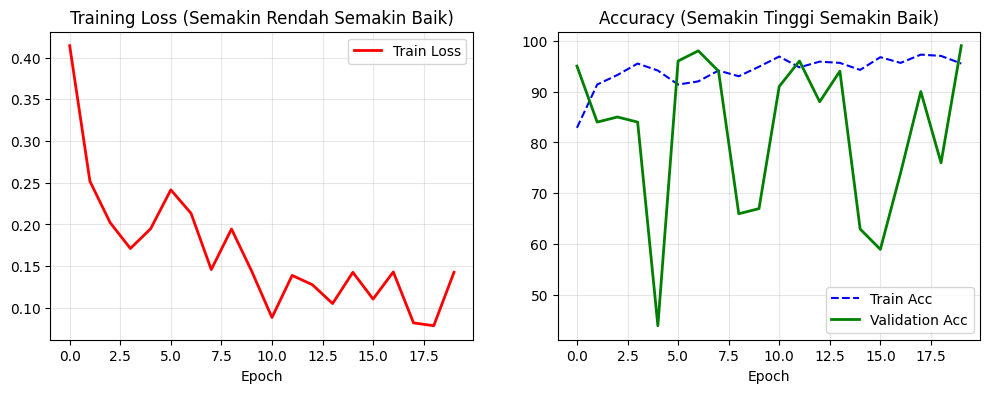

Akurasi Validasi Tertinggi: 99.00%
Model tersimpan di: checkpoints\best_model.pth


In [44]:
if __name__ == "__main__":
    train_complete_notebook()

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [47]:
MODEL_PATH = "checkpoints/best_model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

In [48]:
test_ds = DeepfakeDataset(TEST_LIST, is_train=False)

In [49]:
def run_testing():
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Total Sampel: {len(test_ds)}")

    model = SimpleAudioCNN().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    model.eval()
    all_preds = []
    all_labels = []
    
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    acc = accuracy_score(all_labels, all_preds) * 100
    print(f"AKURASI TEST: {acc:.2f}%")
    
    target_names = ['Bonafide (Asli)', 'Spoof (Palsu)']
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

Total Sampel: 100
AKURASI TEST: 99.00%
                 precision    recall  f1-score   support

Bonafide (Asli)       1.00      0.98      0.99        53
  Spoof (Palsu)       0.98      1.00      0.99        47

       accuracy                           0.99       100
      macro avg       0.99      0.99      0.99       100
   weighted avg       0.99      0.99      0.99       100



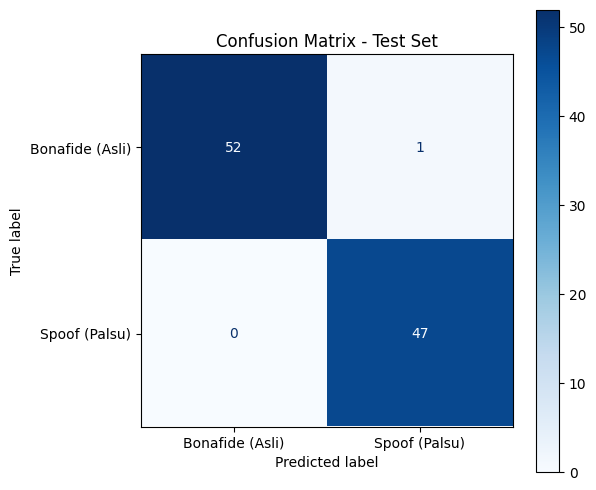

In [50]:
run_testing()